<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/JB_PJ_Time_series_2_Annual_water_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

31.2 Problem Description

The problem is to predict annual water usage. The dataset provides the annual water usage
in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per
capita per day, and there are 79 observations. The dataset is credited to Hipel and McLeod,
1994 . Below is a sample of the first few rows of the dataset.

In [ ]:
# evaluate the finalized model on the validation dataset
import warnings
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import Grouper
from pandas import Series
import numpy as np
from matplotlib import pyplot
import seaborn as sns; sns.set()
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log

In [ ]:
#Load and split data
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/yearly-water-usage.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot()

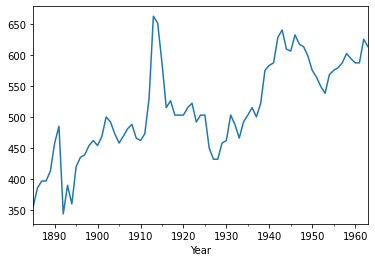

In [4]:
#split_point = int(len(series) * 0.7)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# Persistence

In [3]:
X = dataset.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

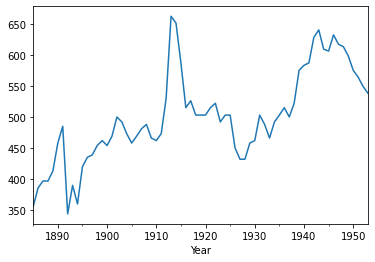

In [6]:
series=dataset
series.plot()
pyplot.show()

There may be some benefit in explicitly modeling the trend component and removing it. You
may also explore using differencing with one or two levels in order to make the series stationary

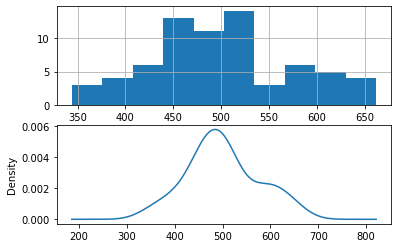

In [8]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

 The distribution is not Gaussian, but is pretty close.

 The distribution has a long right tail and may suggest an exponential distribution or a
double Gaussian.

This suggests it may be worth exploring some power transforms of the data prior to modeling.

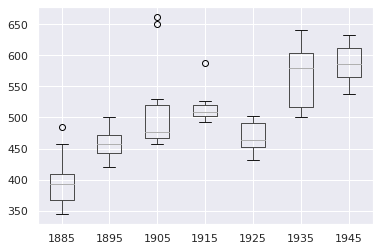

In [13]:
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
  if len(group.values) is 10:
    decades[name.year] = group.values
decades.boxplot()
pyplot.show()

 The median values for each year (red line) may show an increasing trend that may not be
linear.

 The spread, or middle 50% of the data (blue boxes), does show some variability.

 There maybe outliers in some decades (crosses outside of the box and whiskers).

 The second to last decade seems to have a lower average consumption, perhaps related to
the first world war.

# ARIMA Models

# Manually Configured ARIMA

In [18]:
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff)

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


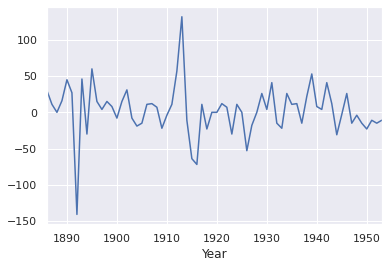

In [19]:
# difference data
series=dataset
X = series.values
X = X.astype('float32')
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()

Running the example outputs the result of a statistical significance test of whether the
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This
suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that
the process has no unit root, and in turn that the time series is stationary or does not have
time-dependent structure.

This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1. A plot of the differenced data is also created. It
suggests that this has indeed removed the increasing trend

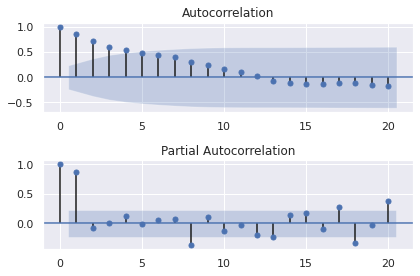

In [21]:
series = dataset
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca())
pyplot.tight_layout()
pyplot.show()

Run the example and review the plots for insights into how to set the p and q variables for
the ARIMA model. Below are some observations from the plots.

 The ACF shows significant lags to 4 time steps.

 The PACF shows significant lags to 1 time step.

A good starting point for the p is 4 and q is 1.

This quick analysis suggests an ARIMA(4,1,1) on the raw data may be a good starting point.
The complete manual ARIMA example is listed below.

In [22]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# prepare data
X = dataset
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(4,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=548.319, Expected=503.000
>Predicted=545.085, Expected=503.000
>Predicted=546.061, Expected=515.000
>Predicted=550.660, Expected=522.000
>Predicted=552.011, Expected=492.000
>Predicted=519.221, Expected=503.000
>Predicted=527.953, Expected=503.000
>Predicted=534.026, Expected=450.000
>Predicted=474.119, Expected=432.000
>Predicted=456.458, Expected=432.000
>Predicted=465.408, Expected=458.000
>Predicted=481.425, Expected=462.000
>Predicted=476.156, Expected=503.000
>Predicted=511.083, Expected=488.000
>Predicted=497.183, Expected=466.000
>Predicted=460.301, Expected=492.000
>Predicted=506.310, Expected=503.000
>Predicted=515.928, Expected=515.000
>Predicted=516.368, Expected=500.000
>Predicted=504.364, Expected=522.000
>Predicted=525.885, Expected=575.000
>Predicted=579.358, Expected=583.000
>Predicted=575.313, Expected=587.000
>Predicted=573.357, Expected=628.000
>Predicted=622.134, Expected=640.000
>Predicted=632.300, Expected=609.000
>Predicted=595.784, Expected=606.000
>

# Grid Search ARIMA Hyperparameters

In [25]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset  
series = dataset
# evaluate parameters
p_values = range(0,5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.346
ARIMA(0, 1, 0) RMSE=22.311
ARIMA(0, 1, 1) RMSE=22.258
ARIMA(0, 1, 2) RMSE=28.430
ARIMA(0, 1, 3) RMSE=30.054
ARIMA(0, 1, 4) RMSE=30.029
ARIMA(0, 2, 0) RMSE=29.335
ARIMA(0, 2, 1) RMSE=23.072
ARIMA(0, 2, 2) RMSE=22.954
ARIMA(1, 0, 0) RMSE=23.958
ARIMA(1, 0, 1) RMSE=23.998
ARIMA(1, 0, 2) RMSE=25.412
ARIMA(1, 0, 3) RMSE=28.865
ARIMA(1, 1, 0) RMSE=22.270
ARIMA(1, 2, 0) RMSE=27.786
ARIMA(1, 2, 1) RMSE=22.979
ARIMA(2, 0, 0) RMSE=24.131
ARIMA(2, 0, 1) RMSE=24.140
ARIMA(2, 1, 0) RMSE=22.084
ARIMA(2, 2, 0) RMSE=25.616
ARIMA(3, 0, 0) RMSE=24.183
ARIMA(3, 0, 1) RMSE=24.636
ARIMA(3, 1, 0) RMSE=25.060
ARIMA(3, 1, 1) RMSE=32.092
ARIMA(3, 2, 0) RMSE=26.126
ARIMA(3, 2, 1) RMSE=25.594
ARIMA(4, 0, 0) RMSE=25.113
ARIMA(4, 0, 1) RMSE=25.122
ARIMA(4, 1, 0) RMSE=26.213
ARIMA(4, 1, 1) RMSE=31.097
ARIMA(4, 1, 2) RMSE=32.604
ARIMA(4, 2, 0) RMSE=27.798
ARIMA(4, 2, 1) RMSE=26.394
ARIMA(4, 2, 2) RMSE=27.393
Best ARIMA(2, 1, 0) RMSE=22.084


We will select this ARIMA(2,1,0) model going forward.

# Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of
residual errors should be a Gaussian with a zero mean. We can check this by using summary
statistics and plots to investigate the residual errors from the ARIMA(2,1,0) model. The example
below calculates and summarizes the residual forecast errors.

RMSE: 21.733
               0
count  35.000000
mean    1.081625
std    22.022566
min   -52.103811
25%   -16.202280
50%    -0.459805
75%    12.085093
max    51.284333


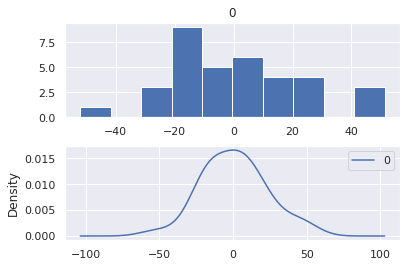

In [31]:
# plot residual errors for ARIMA model
# prepare data
series=dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Running the example first describes the distribution of the residuals. We can see that the
distribution has a right shift and that the mean is non-zero at 1.081624. This is perhaps a sign
that the predictions are biased.

We could use this information to bias-correct predictions by adding the mean residual error
of 1.081624 to each forecast made. The example below performs this bias-correction.

RMSE: 21.706
                  0
count  3.500000e+01
mean   6.256219e-07
std    2.202257e+01
min   -5.318544e+01
25%   -1.728390e+01
50%   -1.541429e+00
75%    1.100347e+01
max    5.020271e+01


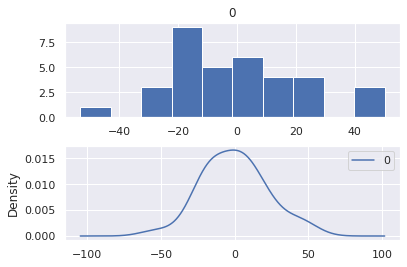

In [30]:
series=dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = bias + float(model_fit.forecast()[0])
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

# Model Validation

Dataset 69, Validation 10
>Predicted=540.013, Expected=568.000
>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000
RMSE: 16.532


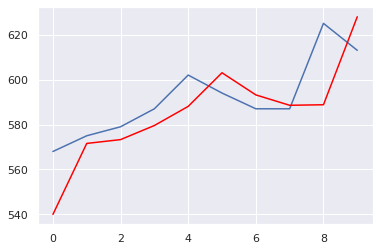

In [32]:
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

X = dataset.values.astype('float32')
history = [x for x in X]

y = validation.values.astype('float32')

# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = 1.081624

# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
  # predict
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = bias + float(model_fit.forecast()[0])
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()